In [129]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas.io.data as web

%matplotlib inline

In [116]:
# step 1: Range Selection
st = dt.datetime(2007,12,1)
en = dt.datetime(2016,1,1)
sp500_tickers_all = ["A", "AA", "AAL", "AAP", "AAPL", "ABBV", "ABC", "ABT", "ACN", "ADBE", "ADI", "ADM", "ADP", "ADS", "ADSK", "ADT", "AEE", "AEP", "AES", "AET", "AFL", "AGN", "AIG", "AIV", "AIZ", "AKAM", "ALL", "ALLE", "ALXN", "AMAT", "AME", "AMG", "AMGN", "AMP", "AMT", "AMZN", "AN", "ANTM", "AON", "APA", "APC", "APD", "APH", "ARG", "ATVI", "AVB", "AVGO", "AVY", "AWK", "AXP", "AZO", "BA", "BAC", "BAX", "BBBY", "BBT", "BBY", "BCR", "BDX", "BEN", "BF.B", "BHI", "BIIB", "BK", "BLK", "BLL", "BMY", "BRK.B", "BSX", "BWA", "BXLT", "BXP", "C", "CA", "CAG", "CAH", "CAM", "CAT", "CB", "CBG", "CBS", "CCE", "CCI", "CCL", "CELG", "CERN", "CF", "CFG", "CHD", "CHK", "CHRW", "CI", "CINF", "CL", "CLX", "CMA", "CMCSA", "CME", "CMG", "CMI", "CMS", "CNP", "COF", "COG", "COH", "COL", "COP", "COST", "CPB", "CPGX", "CRC", "CRM", "CSCO", "CSRA", "CSX", "CTAS", "CTL", "CTSH", "CTXS", "CVC", "CVS", "CVX", "CXO", "D", "DAL", "DD", "DE", "DFS", "DG", "DGX", "DHI", "DHR", "DIS", "DISCA", "DISCK", "DLPH", "DLTR", "DNB", "DO", "DOV", "DOW", "DPS", "DRI", "DTE", "DUK", "DVA", "DVN", "EA", "EBAY", "ECL", "ED", "EFX", "EIX", "EL", "EMC", "EMN", "EMR", "ENDP", "EOG", "EQIX", "EQR", "EQT", "ES", "ESRX", "ESS", "ESV", "ETFC", "ETN", "ETR", "EW", "EXC", "EXPD", "EXPE", "EXR", "F", "FAST", "FB", "FCX", "FDX", "FE", "FFIV", "FIS", "FISV", "FITB", "FLIR", "FLR", "FLS", "FMC", "FOX", "FOXA", "FRT", "FSLR", "FTI", "FTR", "GAS", "GD", "GE", "GGP", "GILD", "GIS", "GLW", "GM", "GME", "GOOG", "GOOGL", "GPC", "GPS", "GRMN", "GS", "GT", "GWW", "HAL", "HAR", "HAS", "HBAN", "HBI", "HCA", "HCN", "HCP", "HD", "HES", "HIG", "HOG", "HON", "HOT", "HP", "HPE", "HPQ", "HRB", "HRL", "HRS", "HSIC", "HST", "HSY", "HUM", "IBM", "ICE", "IFF", "ILMN", "INTC", "INTU", "IP", "IPG", "IR", "IRM", "ISRG", "ITW", "IVZ", "JBHT", "JCI", "JEC", "JNJ", "JNPR", "JPM", "JWN", "K", "KEY", "KHC", "KIM", "KLAC", "KMB", "KMI", "KMX", "KO", "KORS", "KR", "KSS", "KSU", "L", "LB", "LEG", "LEN", "LH", "LLL", "LLTC", "LLY", "LM", "LMT", "LNC", "LOW", "LRCX", "LUK", "LUV", "LVLT", "LYB", "M", "MA", "MAC", "MAR", "MAS", "MAT", "MCD", "MCHP", "MCK", "MCO", "MDLZ", "MDT", "MET", "MHFI", "MHK", "MJN", "MKC", "MLM", "MMC", "MMM", "MNK", "MNST", "MO", "MON", "MOS", "MPC", "MRK", "MRO", "MS", "MSFT", "MSI", "MTB", "MU", "MUR", "MYL", "NAVI", "NBL", "NDAQ", "NEE", "NEM", "NFLX", "NFX", "NI", "NKE", "NLSN", "NOC", "NOV", "NRG", "NSC", "NTAP", "NTRS", "NUE", "NVDA", "NWL", "NWS", "NWSA", "O", "OI", "OKE", "OMC", "ORCL", "ORLY", "OXY", "PAYX", "PBCT", "PBI", "PCAR", "PCG", "PCLN", "PDCO", "PEG", "PEP", "PFE", "PFG", "PG", "PGR", "PH", "PHM", "PKI", "PLD", "PM", "PNC", "PNR", "PNW", "POM", "PPG", "PPL", "PRGO", "PRU", "PSA", "PSX", "PVH", "PWR", "PX", "PXD", "PYPL", "QCOM", "QRVO", "R", "RAI", "RCL", "REGN", "RF", "RHI", "RHT", "RIG", "RL", "ROK", "ROP", "ROST", "RRC", "RSG", "RTN", "SBUX", "SCG", "SCHW", "SE", "SEE", "SHW", "SIG", "SJM", "SLB", "SLG", "SNA", "SNDK", "SNI", "SO", "SPG", "SPLS", "SRCL", "SRE", "STI", "STJ", "STT", "STX", "STZ", "SWK", "SWKS", "SWN", "SYF", "SYK", "SYMC", "SYY", "T", "TAP", "TDC", "TE", "TEL", "TGNA", "TGT", "THC", "TIF", "TJX", "TMK", "TMO", "TRIP", "TROW", "TRV", "TSCO", "TSN", "TSO", "TSS", "TWC", "TWX", "TXN", "TXT", "TYC", "UA", "UAL", "UDR", "UHS", "UNH", "UNM", "UNP", "UPS", "URBN", "URI", "USB", "UTX", "V", "VAR", "VFC", "VIAB", "VLO", "VMC", "VNO", "VRSK", "VRSN", "VRTX", "VTR", "VZ", "WAT", "WBA", "WDC", "WEC", "WFC", "WFM", "WHR", "WLTW", "WM", "WMB", "WMT", "WRK", "WU", "WY", "WYN", "WYNN", "XEC", "XEL", "XL", "XLNX", "XOM", "XRAY", "XRX", "XYL", "YHOO", "YUM", "ZBH", "ZION", "ZTS"]
sp500_tickers_med = ["A", "AA", "AAL", "AAP", "AAPL", "ABBV", "ABC", "ABT", "ACN", "ADBE", "ADI", "ADM", "ADP", "ADS", "ADSK", "ADT", "AEE", "AEP", "AES", "AET", "AFL", "AGN", "AIG", "AIV", "AIZ", "AKAM", "ALL", "ALLE", "ALXN", "AMAT", "AME", "AMG", "AMGN", "AMP", "AMT", "AMZN", "AN", "ANTM", "AON", "APA", "APC", "APD", "APH", "ARG", "ATVI", "AVB", "AVGO", "AVY", "AWK", "AXP", "AZO"]
sp500_tickers_lil = ['AA','AAPL','ABC','ABT','ADBE','ADI','ADM','ADP','ADSK','AEE']
sp500_tickers_joey = ['AA','AAPL','ABC','ABT','ADBE','ADI','ADM','ADP','ADSK','AEE','AEP','AES','AET','AFL','AGN','AIG','AIV','AIZ','AKAM','ALL','AMAT','AMGN','AMP','AMT','AMZN','AN','ANTM','AON','APA','APC','APD','AVB','AVY','AXP','AZO','BA','BAC','BAX','BBBY','BBT','BBY','BCR','BDX','BEN','BFB','BHI','BIIB','BK','BLL','BMY','BRCM','BSX','BXP','C','CA','CAG','CAH','CAT','CB','CBG','CBS','CCE','CCL','CELG','CHK','CHRW','CI','CINF','CL','CLX','CMA','CMCSA','CME','CMI','CMS','CNP','CNX','COF','COH','COL','COP','COST','CPB','CSCO','CSX','CTAS','CTL','CTSH','CTXS','CVS','CVX','D','DD','DE','DFS','DGX','DHI','DHR','DIS','DOV','DOW','DRI','DTE','DUK','DVN','EA','EBAY','ECL','ED','EFX','EIX','EL','EMC','EMN','EMR','EOG','EQR','ESRX','ETFC','ETN','ETR','EXC','EXPD','EXPE','F','FCX','FDX','FE','FIS','FISV','FITB','FLR','FOXA','FTR','GAS','GD','GE','GILD','GIS','GLW','GME','GOOGL','GPC','GPS','GS','GT','GWW','HAL','HAR','HAS','HBAN','HD','HES','HIG','HOG','HON','HOT','HPQ','HRB','HST','HSY','HUM','IBM','ICE','IFF','INTC','INTU','IP','IPG','ITW','JCI','JEC','JNJ','JNPR','JPM','JWN','K','KEY','KIM','KLAC','KMB','KO','KR','KSS','L','LB','LEG','LEN','LH','LLL','LLTC','LLY','LM','LMT','LNC','LOW','LUK','LUV','M','MAR','MAS','MAT','MCD','MCHP','MCK','MCO','MDLZ','MDT','MET','MHFI','MKC','MMC','MMM','MO','MON','MRK','MRO','MS','MSFT','MSI','MTB','MU','MUR','MYL','NBL','NEE','NEM','NI','NKE','NOC','NOV','NSC','NTAP','NTRS','NUE','NVDA','NWL','OMC','ORCL','OXY','PAYX','PBI','PCAR','PCG','PCL','PCP','PDCO','PEG','PEP','PFE','PFG','PG','PGR','PH','PHM','PKI','PLD','PNC','PNW','POM','PPG','PPL','PRU','PSA','PX','QCOM','R','RAI','RF','RHI','RL','ROK','RRC','RTN','SBUX','SCHW','SE','SEE','SHW','SLB','SNA','SNDK','SO','SPG','SPLS','SRE','STI','STJ','STT','STZ','SWK','SYK','SYMC','SYY','T','TAP','TDC','TE','TGT','THC','TIF','TJX','TMK','TMO','TROW','TRV','TSN','TSO','TSS','TWX','TXN','TXT','UNH','UNM','UNP','UPS','USB','UTX','VAR','VFC','VIAB','VLO','VMC','VNO','VRSN','VZ','WAT','WBA','WFC','WFM','WHR','WM','WMB','WMT','WU','WY','WYN','XEL','XL','XLNX','XOM','XRX','YHOO','YUM','ZBH','ZION']

#options
jan = True

In [136]:
regr_coefs = []
k = 0

for ticker in sp500_tickers_joey:
    try:
        data = web.get_data_yahoo(ticker, start=st, end=en)
        k += 1
    except:
        print(ticker, "error")
        continue
        
    
    mdata = data.resample("M").pct_change().dropna()
    Y = mdata["Close"].values# - np.mean(mdata["Close"].values)
    close = mdata["Close"].values
    if jan:
        X = np.zeros([len(close),16]) # 1 constant + 12*mo + 1 2y + 1 3y + January
        X[0::12,-1] = 1
    else:
        X = np.zeros([len(close),15]) # 1 constant + 12*mo + 1 2y + 1 3y
    
    # constant
    X[:,0] = 1
    
    # monthly lags
    for x in range(12):
        X[:,1+x] = np.roll(mdata["Close"].values,1+x)
        X[0:x,1+x] = 0
        
    # 24m lags
    X[:,13] = np.roll(mdata["Close"].values,24)
    X[0:24,13] = 0
    
    # 36m lags
    X[:,14] = np.roll(mdata["Close"].values,36)
    X[0:36,14] = 0
    
    # truncate
    X = X[11:,:]
    Y = Y[11:]
    print("Ticker", ticker, "Regr. Start Date", mdata["Close"].index[11])
        
    #print(X)
    result = sm.OLS(Y,X).fit()
    regr_coefs.append(result.params)
    
#print("done")
avg_coefs = np.mean(np.array(regr_coefs),axis=0)
labels = ["const","1m","2m","3m","4m","5m","6m","7m","8m","9m","10m","11m","12m","24m","36m","Jan"]
for x in zip(labels, avg_coefs):
    print(x)

Ticker AA Regr. Start Date 2008-12-31 00:00:00
Ticker AAPL Regr. Start Date 2008-12-31 00:00:00
Ticker ABC Regr. Start Date 2008-12-31 00:00:00
Ticker ABT Regr. Start Date 2008-12-31 00:00:00
Ticker ADBE Regr. Start Date 2008-12-31 00:00:00
Ticker ADI Regr. Start Date 2008-12-31 00:00:00
Ticker ADM Regr. Start Date 2008-12-31 00:00:00
Ticker ADP Regr. Start Date 2008-12-31 00:00:00
Ticker ADSK Regr. Start Date 2008-12-31 00:00:00
Ticker AEE Regr. Start Date 2008-12-31 00:00:00
Ticker AEP Regr. Start Date 2008-12-31 00:00:00
Ticker AES Regr. Start Date 2008-12-31 00:00:00
Ticker AET Regr. Start Date 2008-12-31 00:00:00
Ticker AFL Regr. Start Date 2008-12-31 00:00:00
Ticker AGN Regr. Start Date 2008-12-31 00:00:00
Ticker AIG Regr. Start Date 2008-12-31 00:00:00
Ticker AIV Regr. Start Date 2008-12-31 00:00:00
Ticker AIZ Regr. Start Date 2008-12-31 00:00:00
Ticker AKAM Regr. Start Date 2008-12-31 00:00:00
Ticker ALL Regr. Start Date 2008-12-31 00:00:00
Ticker AMAT Regr. Start Date 2008-12-

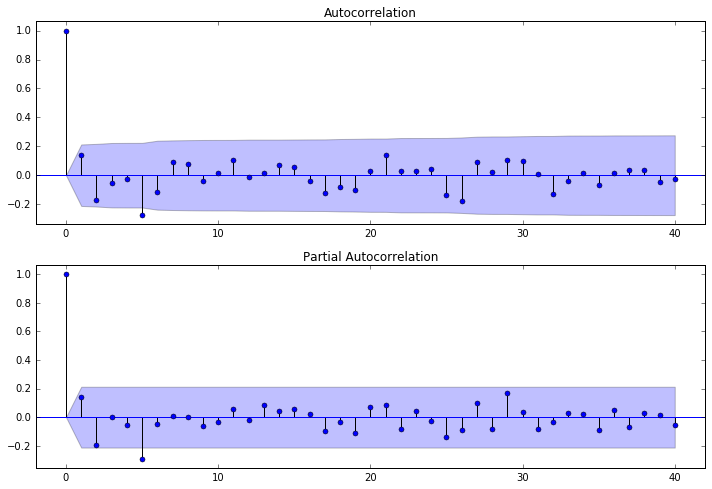

In [130]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Y, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Y, lags=40, ax=ax2)
plt.show()